<small><font color=gray>Notebook author: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a> ©2021 onwards</font></small><hr style="margin:0;background-color:silver">

**[<font size=6>👂Phonemes</font>](https://www.kaggle.com/competitions/16oct23hse-phonemes/rules)**. [**Instructions**](https://colab.research.google.com/drive/1owkYjuRGkx050LQnM3b3yTzd0Dr2XbeV) for running Colabs.

<small>**(Optional) CONSENT.** <mark>[ X ]</mark> We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purposes. We understand that sharing is optional and this decision will not affect our grade in any way. <font color=gray><i>(If ok with sharing your Colab for educational purposes, leave "X" in the check box.)</i></font></small>

In [ ]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if your kaggle.json is stored in Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                                           # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
# !cp kaggle.json ~/.kaggle/kaggle.json > log                   # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                              # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v b16oct23hse-phonemes      # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log                          # download competition dataset as a zip file
!unzip -o *.zip >> log                                        # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show                     # print public leaderboard

- competition is now set to: b16oct23hse-phonemes
100% 28.8M/28.8M [00:00<00:00, 110MB/s]
Using competition: b16oct23hse-phonemes
  teamId  teamName                                        submissionDate       score    
--------  ----------------------------------------------  -------------------  -------  
11111161  Z                                               2023-11-12 10:23:44  0.93800  
11112560  W                                               2023-11-12 12:03:37  0.93500  
11231051  U team                                          2023-11-12 08:05:22  0.93140  
11094096  C                                               2023-11-12 13:45:18  0.93060  
11230233  V                                               2023-11-12 15:32:42  0.93060  
11230846  G (Anna Pronina, Enci Li)                       2023-11-12 14:33:31  0.93040  
11224470  I                                               2023-11-12 16:27:19  0.93000  
11115547  AA                                              2023-11-12 

In [ ]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, cv2, skimage, xgboost, lightgbm as lgb, librosa
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA, LinearDiscriminantAnalysis as LDA
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=2, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)

CPU times: user 254 ms, sys: 2.04 ms, total: 256 ms
Wall time: 263 ms


In [ ]:
df = pd.read_csv('XY_Phonemes.csv', low_memory=False); df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x249,x250,x251,x252,x253,x254,x255,x256,SpkrID,g
0,11.14,15.17,19.12,18.78,13.79,18.98,20.09,19.16,17.32,19.76,...,7.79,10.95,10.05,8.67,10.84,9.50,7.96,9.04,0,NaN
1,10.84,15.20,19.80,17.82,14.10,17.93,19.54,20.97,16.65,22.41,...,12.95,13.05,11.95,11.07,10.81,9.71,11.57,12.22,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59998,12.15,15.78,21.27,19.61,15.14,21.44,23.24,20.91,17.42,21.22,...,8.82,8.00,7.44,8.32,6.51,8.33,6.83,7.02,436,ao
59999,14.78,14.08,15.70,15.51,15.36,15.52,14.68,15.57,15.48,15.45,...,12.87,13.26,13.16,12.65,13.90,13.10,11.16,13.53,436,sh


In [ ]:
df.info()   # observe datatypes and any missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 258 entries, x1 to g
dtypes: float64(256), int64(1), object(1)
memory usage: 118.1+ MB


In [ ]:
# Change string labels to numbers in order of increasing size of the entity (Star < Quasi Star < Galaxy)
# df.Class = df.Class.apply(lambda C: -1 if C=='S' else 0 if C=='Q' else 1 if C=='G' else None)

In [ ]:
vX = df.query('g!=g').drop('g', axis=1)  # slice a test sample (10K observations)
tXY = df.query('g==g')                   # slice training sample
tX, tY = tXY.drop('g', axis=1), tXY.g    # split into training I/O (60K-10K = 50K observation)

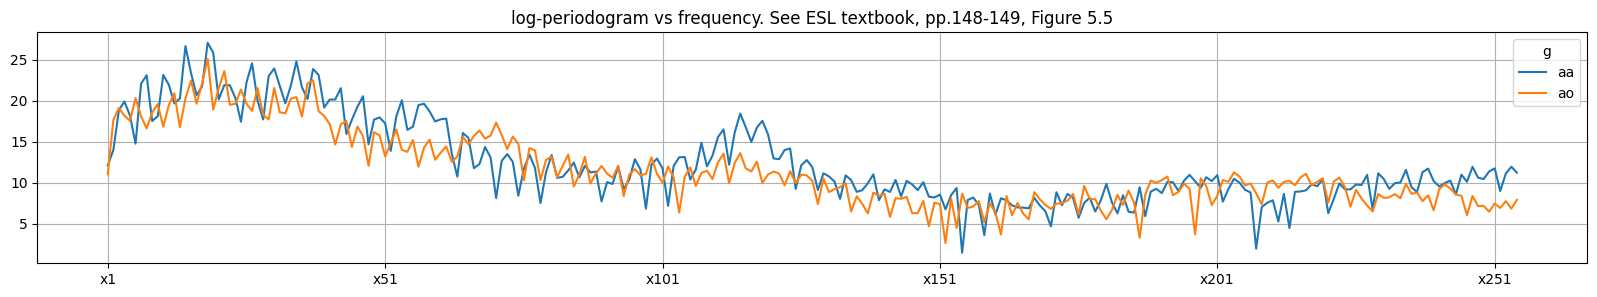

In [ ]:
aa = tXY[tXY.g=='aa'].set_index('g').iloc[[0],0:255]
ao = tXY[tXY.g=='ao'].set_index('g').iloc[[0],0:255]
_ = pd.concat([aa,ao]).T.plot(figsize=(20,3), grid=True, title='log-periodogram vs frequency. See ESL textbook, pp.148-149, Figure 5.5');

In [ ]:
tmr = Timer()

⏳ started. You have 60 sec. Good luck!


<hr color=green size=40>

<strong><font color=green size=5>⏳Timed Green Playground (TGP): Your ideas, code, documentation, and timer START HERE!</font></strong>

<font color=green>Students: Keep all your definitions, code, documentation in <b>TGP</b>. Modifying any code outside of TGP incurs penalties.

<font color=green><h3><b>$\alpha$. Build polynomial features</b><h3>

In [ ]:
df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x249,x250,x251,x252,x253,x254,x255,x256,SpkrID,g
0,11.14,15.17,19.12,18.78,13.79,18.98,20.09,19.16,17.32,19.76,...,7.79,10.95,10.05,8.67,10.84,9.50,7.96,9.04,0,NaN
1,10.84,15.20,19.80,17.82,14.10,17.93,19.54,20.97,16.65,22.41,...,12.95,13.05,11.95,11.07,10.81,9.71,11.57,12.22,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59998,12.15,15.78,21.27,19.61,15.14,21.44,23.24,20.91,17.42,21.22,...,8.82,8.00,7.44,8.32,6.51,8.33,6.83,7.02,436,ao
59999,14.78,14.08,15.70,15.51,15.36,15.52,14.68,15.57,15.48,15.45,...,12.87,13.26,13.16,12.65,13.90,13.10,11.16,13.53,436,sh


# Data Preparation

## Cubic Splines

Described in ESL textbook

In [ ]:
from patsy import dmatrix
def create_splines(data):
    transformed_data = pd.DataFrame()
    for col in data.select_dtypes(include=np.number).columns:
        spline = dmatrix("cr(data, df=4) - 1", {"data": data[col]}, return_type='dataframe') # df=4 это примерное значение
        transformed_data = pd.concat([transformed_data, spline], axis=1)
    return transformed_data

tY = df['g'][10000:]
df = df.drop(columns=['g', 'SpkrID'])
df_spline = create_splines(df)

In [ ]:
print(f'{df.shape} -> {df_spline.shape}')

(60000, 256) -> (60000, 1024)


## Data Splitting

In [ ]:
vX = df_spline[:10000]  # slice a test sample (10K observations)
tX, tY = df_spline[10000:], tY    # split into training I/O (60K-10K = 50K observation)

In [ ]:
from sklearn.model_selection import train_test_split

X, y = tX, tY.values
# data is split in a stratified fashion
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, train_size=48000, random_state=7, stratify=y)

In [ ]:
# %%time
# n = 1000   # validation subsample
# vX0, vY0 = tX.iloc[:n,:], tY[:n]   # subsample for model selection experiments
# tX0, tY0 = tX.iloc[-n:,:], tY[-n:] # subsample for model training

# # poly = PolynomialFeatures(degree=2)    # add non-linear features (powers and interactions)
# # tX0p = poly.fit_transform(tX0.select_dtypes(include=np.number))  # create object on training set
# # vX0p = poly.transform(vX0.select_dtypes(include=np.number))      # apply the same object to test set
# # vXp  = poly.transform(vX.select_dtypes(include=np.number))       # apply the same object to test set

# Model building

## LDA

BEST from what i've got

In [ ]:
just_lda = LDA(solver='lsqr').fit(X_train, y_train)
print(just_lda.score(X_test, y_test))

0.958


## Ensemble of models


0.9324 on kaggle(

In [ ]:
# from statistics import mode

# # Prep of data
# X_train1, X_train2, X_train3 = X_train[:16000], X_train[16000:32000], X_train[-16000:]
# y_train1, y_train2, y_train3 = y_train[:16000], y_train[16000:32000], y_train[-16000:]
# X_test, y_test = X_test, y_test

# # Prep of models
# m_lda1 = LDA(solver='lsqr').fit(X_train1, y_train1)
# m_lda2 = LDA(solver='lsqr').fit(X_train2, y_train2)
# m_lda3 = LDA(solver='lsqr').fit(X_train3, y_train3)

# # Separate results
# print(m_lda1.score(X_test, y_test))
# print(m_lda2.score(X_test, y_test))
# print(m_lda3.score(X_test, y_test))

# # Prep of results
# m_lda1_pred, m_lda2_pred, m_lda3_pred = m_lda1.predict(vX), m_lda2.predict(vX), m_lda3.predict(vX)
# final_pred = [mode([a, b, c]) for a, b, c in zip(m_lda1_pred, m_lda2_pred, m_lda3_pred)]

# pY = pd.DataFrame(final_pred, index=range(1,len(vX)+1), columns=['g'])  # ensure that labels and observations are in corresponding order
# pd.DataFrame(pY.value_counts(sort=False)).rename(columns={0:'predicted output g'}).T
# ToCSV(pY, '👂Baseline')

## KNN

cool score in collab, but much lower score on kaggle (HUGE OVERFITTING)

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier as KNN

# knn = KNN(n_neighbors=5)  # You can adjust the number of neighbors
# print(knn.fit(X_train, y_train).score(X_test, y_test))  # Fit the model and show test accuracy

## NB

lower score than LDA, similar to what on kaggle result

In [ ]:
# from sklearn.naive_bayes import GaussianNB as NB

# nb = NB()
# print(nb.fit(X_train, y_train).score(X_test, y_test))  # Fit the model and show test accuracy

## LR

Good score, but time complexity is too high to enter the 60sec limits

In [ ]:
# lr = LR(
#     solver='lbfgs', max_iter=100000, C=1e43, tol=1e-100
# ).fit(X_train, y_train)

# print(lr.score(X_test, y_test))

# Generate predictions

In [ ]:
pY = pd.DataFrame(just_lda.predict(vX), index=range(1,len(vX)+1), columns=['g'])  # ensure that labels and observations are in corresponding order
pd.DataFrame(pY.value_counts(sort=False)).rename(columns={0:'predicted output g'}).T
ToCSV(pY, '👂Baseline')

g,aa,ao,dcl,iy,sh
predicted output g,1431,2352,1644,2629,1944


# Documentation

<font color=green><h4><b>Task 1. Explain Decisions in Preprocessing Pipeline</b></h4></font>

<font color=green>
Explain elements of your preprocessing pipeline i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.</font>

<font color=green>

1. Why did you choose these elements? (Something in EDA, prior experience,...? Note: EDA is not required)
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

</font>

1. Nothing much in preprocessing was done, except cubic splines, described in ESL textbook. Cubic splines played the main role in increasing accuracy. I assume it is due to some shaded non-linear dependencies, which i couldn't capture with polynomialDegree, as it exceeded by RAM.
2. I've just printed accuracy for each model and with each change in preprocessing, trying to describe effectiveness like that.
3. I've tried PCA to reduce dimensionality and further use cubic splines/polynomial degree, as the size passed the ram test. However accuracy didn't increase. *Moreover i've tried some forecasting on 'SpkrID', as i thought one speaker speeks continuesly, i've calculated avg number of rows for each speaker and got roughly 130rows/speaker. => i could use forecasting for each speaker to understand which phoneme he would say, but i've decided not to use this approach as >450 forecasts are time-consuming and it is relatively hard approach for such task((.* Also i've found code relating to ESL textbook phoneme in github in which difference between 'ao' and 'aa' with cubic splines was described, but i didn't understand how to implement difference between two phonemes into clastering task in order to increase distinctiveness between the two most related phonemes.

<font color=green><h4><b>Task 2. Explain Decisions in Modeling Pipeline</b></h4></font>

<font color=green>
Explain your modeling approach, i.e. ideas you tried and why you thought they would be helpful.

1. How did these decisions guide you in modeling?
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

</font>

1. Firstly i've tried different modeling approaches. I've tested all adviced models separately (tryed to find suitable hyperparameters using GridSearchCV), also ensambled models were testes. And eventually, i've achieved the best score using just LDA model, not only by time but also by accuracy.
2. Just regular .score was used to evaluate effectiveness
3. Logistic Regression, k-nearest neighbors algorithm, quadratic discriminant analysis, Naïve Bayes. Didn't succeed.

<font color=green><h3><b>$\zeta$. References</b></h3></font>

1. [LDA wikipedia](https://en.wikipedia.org/wiki/Linear_discriminant_analysis)
2. [Scikit Learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.discriminant_analysis)
3. [ESL git code phoneme](https://github.com/empathy87/The-Elements-of-Statistical-Learning-Python-Notebooks/blob/master/examples/Phoneme%20Recognition.ipynb)
4. [ISL textbook](https://hastie.su.domains/ISLP/ISLP_website.pdf.download.html)
5. [ESL textbook](https://hastie.su.domains/Papers/ESLII.pdf)

<font size=5>⌛</font> <strong><font color=green size=5>Do not exceed competition's runtime limit! Do not write code outside TGP</font></strong>
<hr color=green size=40>

In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 59 sec


## 💡**Starter Ideas**

1. Tune model hyperparameters
1. Try smarter sampling from the training set to avoid using all observations (due to time constraint) and, instead, develop more features
1. Try feature restriction, selection, and regularization (see ESL pp.140-141)
1. Do a thorough EDA: look for feature augmentations that result in linear decision boundaries between pairs of classes.
1. Try encoding and/or incorporating speaker ID. For example, you could scale/transform each speaker's observations separately.
1. Carefully read the example in [ESL textbook, p.149](https://hastie.su.domains/ElemStatLearn/printings/ESLII_print12.pdf#page=168), check seminar Colab and lecture slides
1. Check difference in distribution between test and train data. You might consider [group k-fold](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) for testing locally or your model will memorize user-phoneme releation, instead of phoneme attributes and class.
1. Learn the domain to develop better features. See ["Penalized discriminant analysis"](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C48&q=Penalized+Discriminant+Analysis&btnG=)
1. Look for training outliers that can affect your model's test performance.
  1. Essentially, you need to find and exclude training [influential points](https://en.wikipedia.org/wiki/Influential_observation), but training outliers might be influential
  1. Brute force with [LOOCV](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#Leave-one-out_cross-validation) is slow, but robust. You might find methods to find each training point's contribution to the prediction and remove rare extreme contributors (since they may not be in the test set)
  1. You can find outliers; then evaluate their effect on model's performance
    1. You can evaluate 1D and 2D histograms to find outliers and
    1. You can cluster observations and find outliers that don't fit the clusters (DBSCAN may be helpful)
    1. You can compress high dimensional space to 1D (with PCA, tSNE, UMAP) and then find outliers with a histogram
 1. Additional info:
    1. Harmonics: [wiki](https://en.wikipedia.org/wiki/Harmonic), [sinusoidal regression](https://www.youtube.com/results?search_query=regression+sinusoidal)
    1. Discrete Fourier Transofrm (DFT): [wiki](https://en.wikipedia.org/wiki/Discrete_Fourier_transform), [Steve Brunton @UW](https://www.youtube.com/watch?v=nl9TZanwbBk), [YouTube search](https://www.youtube.com/results?search_query=Discrete+Fourier+transform)
    1. Spectral density estimation [(wiki)](https://en.wikipedia.org/wiki/Spectral_density_estimation), [YouTube search](https://www.youtube.com/results?search_query=spectral+density+estimation)


